In [15]:
img_rows = 28
img_cols = 28
color_type = 1
batch_size=64
epochs=32
cache = 'e:/kaggle_imgs/cache/digit'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from pickle import load, dump

In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Input
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [4]:
# import module
import os
import cv2

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
y_train=train.label
x_train=train.drop(labels = ["label"],axis = 1) 
del train
x_train = x_train / 255.0
test = test / 255.0
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
y_train = to_categorical(y_train, num_classes = 10)
train_images, valid_images, train_labels, valid_labels = train_test_split(x_train, y_train, 
                                                  test_size = 0.1, 
                                                  random_state=2)

In [7]:
# stats
train_size = len(train_images)
valid_size = len(valid_images)
test_size = (test.shape[0])
print('stats:', flush=True)
print('{} train images'.format(train_size), flush=True)
print('{} validation images'.format(valid_size), flush=True)
print('{} test images'.format(test_size), flush=True)
print('train_images.shape = {}'.format(train_images.shape), flush=True)
print('train_labels.shape = {}'.format(train_labels.shape), flush=True)
print('valid_images.shape = {}'.format(valid_images.shape), flush=True)
print('valid_labels.shape = {}'.format(valid_labels.shape), flush=True)

stats:
37800 train images
4200 validation images
28000 test images
train_images.shape = (37800, 28, 28, 1)
train_labels.shape = (37800, 10)
valid_images.shape = (4200, 28, 28, 1)
valid_labels.shape = (4200, 10)


In [8]:
import shutil
if os.path.exists(cache):
    shutil.rmtree(cache)
os.mkdir(cache)
saved_path="{}/saved_models".format(cache)
if not os.path.exists(saved_path):
    os.makedirs(saved_path)
filepath='{}/weights_best.hdf5'.format(saved_path)

In [9]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_acc",
                                          patience=3,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)
callbacks = [checkpoint, es,learning_rate_reduction]

In [10]:
# def get_model():
#     input_layer = Input((img_rows, img_cols, color_type))
#     x = Conv2D(32, (5, 5),padding="Same",activation="relu",input_shape=(28,28,1))(input_layer)
#     x = Conv2D(32, (5, 5),padding="Same",activation="relu")(input_layer)
#     x = MaxPool2D(pool_size=(2,2))(x)
#     x = Dropout(0.25)(x)
#     x = Conv2D(64, (3, 3),padding="Same",activation="relu")(input_layer)
#     x = Conv2D(64, (3, 3),padding="Same",activation="relu")(input_layer)
#     x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
#     x = Dropout(0.25)(x)
#     x = Flatten()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     predictions = Dense(10, activation='softmax')(x)
#     return model
def get_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    return model


model = get_model()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [11]:
# data augmentation configuration
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_images)

In [12]:
training_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
validation_data = (valid_images,valid_labels)

In [16]:
history = model.fit_generator(
    training_generator,
    epochs = epochs, 
    validation_data = validation_data,
    verbose = 1,
    steps_per_epoch = train_images.shape[0] // batch_size,
    callbacks=callbacks,
    validation_steps = valid_images.shape[0] // batch_size)

Epoch 1/32
590/590 [==============================] - 12s 21ms/step - loss: 0.3997 - accuracy: 0.8721 - val_loss: 0.0729 - val_accuracy: 0.9764

Epoch 00001: val_loss improved from inf to 0.07293, saving model to e:/kaggle_imgs/cache/digit/saved_models/weights_best.hdf5
Epoch 2/32
  2/590 [..............................] - ETA: 35s - loss: 0.1651 - accuracy: 0.9531

C:\Users\ipofri-desktop\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


590/590 [==============================] - 9s 16ms/step - loss: 0.1286 - accuracy: 0.9620 - val_loss: 0.0504 - val_accuracy: 0.9852

Epoch 00002: val_loss improved from 0.07293 to 0.05043, saving model to e:/kaggle_imgs/cache/digit/saved_models/weights_best.hdf5
Epoch 3/32
590/590 [==============================] - 9s 15ms/step - loss: 0.0940 - accuracy: 0.9728 - val_loss: 0.0404 - val_accuracy: 0.9876

Epoch 00003: val_loss improved from 0.05043 to 0.04037, saving model to e:/kaggle_imgs/cache/digit/saved_models/weights_best.hdf5
Epoch 4/32
590/590 [==============================] - 9s 16ms/step - loss: 0.0805 - accuracy: 0.9763 - val_loss: 0.0553 - val_accuracy: 0.9848

Epoch 00004: val_loss did not improve from 0.04037
Epoch 5/32
590/590 [==============================] - 9s 15ms/step - loss: 0.0764 - accuracy: 0.9779 - val_loss: 0.0418 - val_accuracy: 0.9895

Epoch 00005: val_loss did not improve from 0.04037
Epoch 6/32
590/590 [==============================] - 9s 16ms/step - loss

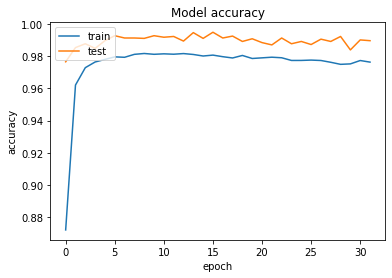

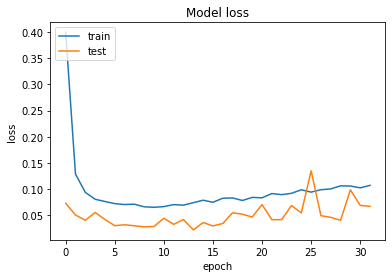

In [17]:
# plot history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [22]:
model.load_weights(filepath)
results=model.predict(test)
results=np.argmax(results,axis=1)
results=pd.Series(results,name="Label")

In [23]:
submission=pd.DataFrame({"ImageId":pd.Series(range(1,28001)),"Label":results.values})

In [24]:
from datetime import datetime
now=datetime.now()
submission.to_csv("data/{0:02d}{1:02d}{2:02d}{3:02d}_keras_submission.csv".format(now.year,now.month,now.day,now.hour),index=False)

In [25]:
641/2856

0.22443977591036415